# Table of Contents

1. [Exploratory Analysis](#Exploratory-Analysis)

In [1]:
import numpy as np
import pandas as pd
import gc
from fbprophet import Prophet


## Stuff below is to load the CSV's through google drive. Way too slow otherwise.

In [2]:
DATA_DIR = "../data/"
CALENDAR_PATH = DATA_DIR + "calendar.csv"
SALES_TRAIN_VALIDATION_PATH = DATA_DIR + "sales_train_validation.csv"
SAMPLE_SUBMISSION_PATH = DATA_DIR + "sample_submission.csv"
SELL_PRICES_PATH = DATA_DIR + "sell_prices.csv"


Loading the data into DataFrames

In [3]:
sell_prices_df = pd.read_csv(SELL_PRICES_PATH)
sales_train_validation_df = pd.read_csv(SALES_TRAIN_VALIDATION_PATH)
calendar_df = pd.read_csv(CALENDAR_PATH)
sell_prices_df.shape, sales_train_val_df.shape

((6841121, 4), (30490, 1919))

### Just taking a gander

In [4]:
sales_train_validation_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [5]:
calendar_df.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [6]:
sell_prices_df.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


Checking out the dtypes - reducing the int64's to make it more memory efficient. Also filling in the NaN's with "unknown"

In [7]:
calendar_df[["month", "snap_CA", "snap_TX", "snap_WI", "wday"]] = \
calendar_df[["month", "snap_CA", "snap_TX", "snap_WI", "wday"]].astype("int8")
calendar_df[["wm_yr_wk", "year"]] = calendar_df[["wm_yr_wk", "year"]].astype("int16") 
calendar_df["date"] = calendar_df["date"].astype("datetime64")

nan_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
for feature in nan_features:
    calendar_df[feature].fillna('unknown', inplace = True)

Seeing what events there are. Not sure how we should encode these but it looks small enough to me to have one hot... looks like it's going to be hella one hot encoding though?

In [8]:
print(calendar_df.event_name_1.unique())
print(calendar_df.event_name_2.unique())

['unknown' 'SuperBowl' 'ValentinesDay' 'PresidentsDay' 'LentStart'
 'LentWeek2' 'StPatricksDay' 'Purim End' 'OrthodoxEaster' 'Pesach End'
 'Cinco De Mayo' "Mother's day" 'MemorialDay' 'NBAFinalsStart'
 'NBAFinalsEnd' "Father's day" 'IndependenceDay' 'Ramadan starts'
 'Eid al-Fitr' 'LaborDay' 'ColumbusDay' 'Halloween' 'EidAlAdha'
 'VeteransDay' 'Thanksgiving' 'Christmas' 'Chanukah End' 'NewYear'
 'OrthodoxChristmas' 'MartinLutherKingDay' 'Easter']
['unknown' 'Easter' 'Cinco De Mayo' 'OrthodoxEaster' "Father's day"]


Ok so if we are going the route of combining the dataframes into one then that should be enough for the calendar for now. Let's look at sales_train_validation

In [9]:
# Turning them into int16's. 
sales_train_validation_df.loc[:, "d_1":] = sales_train_validation_df.loc[:, "d_1":].astype('int16')

# Exploratory Analysis

In [11]:
# Make ID column to sell_price dataframe
sell_prices_df.loc[:, "id"] = sell_prices_df.loc[:, "item_id"] + "_" + sell_prices_df.loc[:, "store_id"] + "_validation"

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [12]:
sell_prices_df = pd.concat([sell_prices_df, sell_prices_df["item_id"].str.split("_", expand=True)], axis=1)
sell_prices_df = sell_prices_df.rename(columns={0:"cat_id", 1:"dept_id"})
sell_prices_df[["store_id", "item_id", "cat_id", "dept_id"]] = sell_prices_df[["store_id","item_id", "cat_id", "dept_id"]].astype("category")
sell_prices_df = sell_prices_df.drop(columns=2)


Copied from kaggle notebook [here](https://www.kaggle.com/ryuheeeei/let-s-start-from-here-beginners-data-analysis)

In [18]:
def make_dataframe():
    # Wide format dataset 
    df_wide_train = sales_train_validation_df.drop(columns=["item_id", "dept_id", "cat_id", "state_id","store_id", "id"]).T
    df_wide_train.index = calendar_df["date"][:1913]
    df_wide_train.columns = sales_train_validation_df["id"]
    
    # Making test label dataset
    df_wide_test = pd.DataFrame(np.zeros(shape=(56, len(df_wide_train.columns))), index=calendar_df.date[1913:], columns=df_wide_train.columns)
    df_wide = pd.concat([df_wide_train, df_wide_test])

    # Convert wide format to long format
    df_long = df_wide.stack().reset_index(1)
    df_long.columns = ["id", "value"]

    del df_wide_train, df_wide_test, df_wide
    gc.collect()
    
    df = pd.merge(pd.merge(df_long.reset_index(), calendar_df, on="date"), sell_prices_df, on=["id", "wm_yr_wk"])
    df = df.drop(columns=["d"])
#     df[["cat_id", "store_id", "item_id", "id", "dept_id"]] = df[["cat_id"", store_id", "item_id", "id", "dept_id"]].astype("category")
    df["sell_price"] = df["sell_price"].astype("float16")   
    df["value"] = df["value"].astype("int32")
    df["state_id"] = df["store_id"].str[:2].astype("category")


    del df_long
    gc.collect()

    return df

df = make_dataframe()

In [41]:
TEST_ID = "HOBBIES_1_008_CA_1_validation"

Copied from FBProphet Quickstart guide [here](https://facebook.github.io/prophet/docs/quick_start.html#python-api)

In [34]:
# Python
m = Prophet()
m.fit(df[df.id == TEST_ID].rename(columns={
    'date': 'ds',
    "value": "y"
})[["ds", "y"]])

# Python
future = m.make_future_dataframe(periods=365)
future.tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
2329,2017-06-15
2330,2017-06-16
2331,2017-06-17
2332,2017-06-18
2333,2017-06-19


In [37]:
# Python
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
2329,2017-06-15,4.384148,-7.495790,14.780977
2330,2017-06-16,5.288482,-5.640115,15.865264
2331,2017-06-17,6.088487,-4.653834,17.245838
2332,2017-06-18,3.880101,-6.401155,15.810936
2333,2017-06-19,4.486575,-7.007844,15.605628


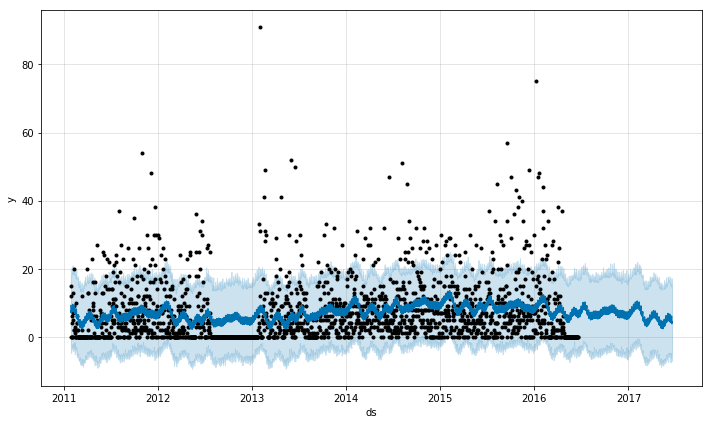

In [39]:
fig1 = m.plot(forecast)

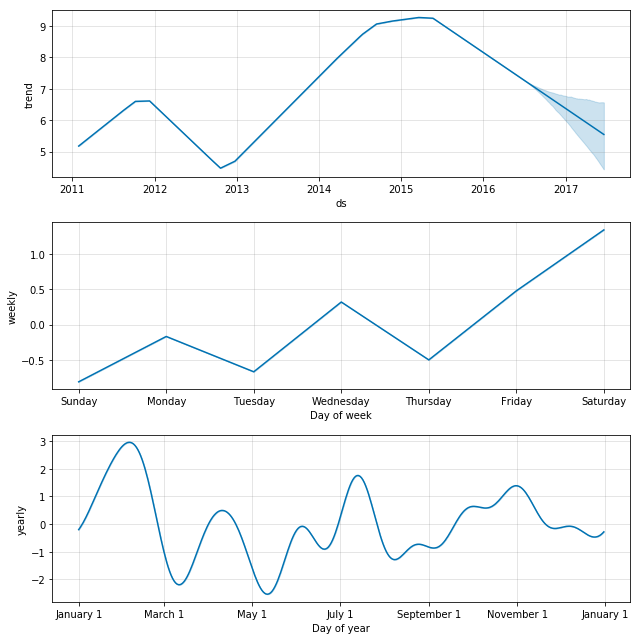

In [40]:
fig2 = m.plot_components(forecast)
